<a href="https://colab.research.google.com/github/qkrwoghd04/ImageCaptionnng_Using_ViT/blob/master/code/Image%26Text_late_fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install BERT for tf2 module
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
# Import all necessary libraries
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Model
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import layers
from keras import layers
from keras import callbacks
from keras import optimizers
from keras import utils
from keras import models
from keras import applications
from keras.regularizers import l2, l1
import bert

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
train_csv_path = r"/content/drive/MyDrive/image_dataset/processed/train_captions.csv"
test_csv_path = r"/content/drive/MyDrive/image_dataset/processed/test_captions.csv"
train_image_path = r'/content/drive/MyDrive/image_dataset/processed/train'
test_image_path = r'/content/drive/MyDrive/image_dataset_splited/test'

# CSV 파일 로드
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
# 이미지 파일 이름이 저장된 컬럼을 'image_path'로 변경합니다.
train_df.rename(columns={'Image': 'image_path', 'Caption': 'caption', 'Label': 'label'}, inplace=True)
test_df.rename(columns={'Image': 'image_path', 'Caption': 'caption', 'Label': 'label'}, inplace=True)

In [ ]:
train_df

,image_path,caption,label
0,Fall_001.jpg,a man falling on the ground in a hallway.,Fall
1,Fall_002.jpg,a person falling on the ground in front of a ...,Fall
2,Fall_003.jpg,a man in a purple shirt falling on the floor.,Fall
3,Fall_004.jpg,a man falling on the ground in a room.,Fall
4,Fall_005.jpg,a man falling on the ground in a room.,Fall
...,...,...,...
395,Sleep_196.jpg,a man lying on top of a blue table.,Sleep
396,Sleep_197.jpg,a woman is lying in bed with her head on a pi...,Sleep
397,Sleep_198.jpg,an image of a man leaning against a wall.,Sleep
398,Sleep_199.jpg,a man lying on a bed in a room with a blue fl...,Sleep


In [ ]:
# 이미지 경로와 라벨을 포함하는 DataFrame 생성
train_df['image_path'] = train_df.apply(lambda row: os.path.join(train_image_path, row['label'], row['image_path']), axis=1)
test_df['image_path'] = test_df.apply(lambda row: os.path.join(test_image_path, row['label'], row['image_path']), axis=1)

In [ ]:
#hyperparameter

image_size = 224
# Parameters setting: images width and height, depth, number if classes, input shape
batch_size =  64
image_width = 224
image_height = 224
depth = 3
max_length = 20 #Setup according to the text

nClasses = train_df.label.nunique()
Classes = train_df.label.unique()
input_shape = (image_width, image_height, depth)

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
def encode_texts(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def preprocess_texts(df, tokenizer, max_len=512):
    tokens, masks, segments = [], [], []
    for _, row in df.iterrows():
        text = row['caption']
        token, mask, segment = encode_texts([text], tokenizer, max_len)
        tokens.append(token[0])
        masks.append(mask[0])
        segments.append(segment[0])
    return np.array(tokens), np.array(masks), np.array(segments)

# 텍스트 데이터를 미리 처리합니다.
train_tokens, train_masks, train_segments = preprocess_texts(train_df, tokenizer, max_length)
test_tokens, test_masks, test_segments = preprocess_texts(test_df, tokenizer, max_length)

# DataFrame에 처리된 텍스트 데이터를 추가합니다.
train_df['tokens'] = list(train_tokens)
train_df['masks'] = list(train_masks)
train_df['segments'] = list(train_segments)

test_df['tokens'] = list(test_tokens)
test_df['masks'] = list(test_masks)
test_df['segments'] = list(test_segments)

In [ ]:
train_df

,image_path,caption,label,tokens,masks,segments
0,/content/drive/MyDrive/image_dataset/processed...,a man falling on the ground in a hallway.,Fall,"[101, 1037, 2158, 4634, 2006, 1996, 2598, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,/content/drive/MyDrive/image_dataset/processed...,a person falling on the ground in front of a ...,Fall,"[101, 1037, 2711, 4634, 2006, 1996, 2598, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,/content/drive/MyDrive/image_dataset/processed...,a man in a purple shirt falling on the floor.,Fall,"[101, 1037, 2158, 1999, 1037, 6379, 3797, 4634...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/content/drive/MyDrive/image_dataset/processed...,a man falling on the ground in a room.,Fall,"[101, 1037, 2158, 4634, 2006, 1996, 2598, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,/content/drive/MyDrive/image_dataset/processed...,a man falling on the ground in a room.,Fall,"[101, 1037, 2158, 4634, 2006, 1996, 2598, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
395,/content/drive/MyDrive/image_dataset/processed...,a man lying on top of a blue table.,Sleep,"[101, 1037, 2158, 4688, 2006, 2327, 1997, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
396,/content/drive/MyDrive/image_dataset/processed...,a woman is lying in bed with her head on a pi...,Sleep,"[101, 1037, 2450, 2003, 4688, 1999, 2793, 2007...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
397,/content/drive/MyDrive/image_dataset/processed...,an image of a man leaning against a wall.,Sleep,"[101, 2019, 3746, 1997, 1037, 2158, 6729, 2114...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
398,/content/drive/MyDrive/image_dataset/processed...,a man lying on a bed in a room with a blue fl...,Sleep,"[101, 1037, 2158, 4688, 2006, 1037, 2793, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    image = preprocess_input(image)
    return image

In [ ]:
def load_image_and_text(image_path, text, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = preprocess_input(image)  # InceptionV3의 전처리 함수

    text_input = tf.py_function(encode_texts, [tf.expand_dims(text, -1), tokenizer, 512], [tf.int32, tf.int32, tf.int32])

    return (image, text_input[0], text_input[1], text_input[2]), label

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def tf_dataset(df, batch_size=32):
    # 텍스트 입력 데이터
    text_ds = tf.data.Dataset.from_tensor_slices((
        np.array(df['tokens'].tolist(), dtype=np.int32),
        np.array(df['masks'].tolist(), dtype=np.int32),
        np.array(df['segments'].tolist(), dtype=np.int32)
    ))

    # 이미지 데이터
    image_ds = tf.data.Dataset.from_tensor_slices(df['image_path'].values)
    image_ds = image_ds.map(load_image, num_parallel_calls=AUTOTUNE)

    # 라벨 데이터
    label_ds = tf.data.Dataset.from_tensor_slices(
        tf.keras.utils.to_categorical(df['label'].map({'Fall': 0, 'Sleep': 1}).values, num_classes=nClasses)
    )

    # 데이터셋 결합 (텍스트, 이미지, 라벨)
    ds = tf.data.Dataset.zip((text_ds, image_ds, label_ds))
    ds = ds.map(lambda x, y, z: ({'input_word_ids': x[0], 'input_mask': x[1], 'segment_ids': x[2], 'image_input': y}, z), num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1024).batch(batch_size).prefetch(AUTOTUNE)

    return ds

# 데이터셋 생성
train_dataset = tf_dataset(train_df)
test_dataset = tf_dataset(test_df)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=({'input_word_ids': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'segment_ids': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'image_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
# BERT 모델 로드
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)

# Vision Transformer 모델 로드
vit_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_classification/1", trainable=True)

In [ ]:
def create_fusion_model(num_classes):
    # BERT 모델 입력을 위한 레이어
    text_input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_word_ids')
    text_input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_mask')
    text_segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='segment_ids')

    # BERT 인코더 출력
    pooled_output, sequence_output = bert_layer([text_input_ids, text_input_mask, text_segment_ids])

    # Vision Transformer(ViT) 입력을 위한 레이어
    image_input = layers.Input(shape=[224, 224, 3], dtype=tf.float32, name='image_input')
    # ViT 인코더 출력
    vit_outputs = vit_layer(image_input)

    # BERT와 ViT의 출력을 결합
    combined = layers.concatenate([pooled_output, vit_outputs])

    # 추가적인 Dense 레이어와 Dropout 레이어
    x = layers.Dense(256, activation='relu', name='Dense_256')(combined)
    x = layers.Dropout(0.5, name='dropout_1')(x)  # 50%의 Dropout 비율
    x = layers.Dense(128, activation='relu', name='Dense_128')(x)
    x = layers.Dropout(0.5, name='dropout_2')(x)

    # 최종 분류 레이어
    classifier = layers.Dense(num_classes, activation='softmax', name='classifier')(x)

    # 멀티모달 모델 생성
    model = Model(inputs=[text_input_ids, text_input_mask, text_segment_ids, image_input], outputs=classifier)

    return model

In [ ]:
fusion_model = create_fusion_model(num_classes=2)

# 모델 컴파일
fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
fusion_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 20)]                 0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 20)]                 0         []                            
                                                                                                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                      

In [ ]:
# Stochastic Gradient Descent optimizer
adam = optimizers.Adam(learning_rate=0.0001)

# Compile model
fusion_model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

In [ ]:
history = fusion_model.fit(
    train_dataset,  # 학습 데이터
    epochs=5,  # 전체 데이터셋에 대해 학습할 반복 횟수
    callbacks=[reduce_lr]  # 학습률 조정을 위한 ReduceLROnPlateau 콜백
)

Epoch 1/5
13/13 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.7700

13/13 [==============================] - 43s 514ms/step - loss: 0.7390 - accuracy: 0.7700 - lr: 1.0000e-04
Epoch 2/5
13/13 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9525

13/13 [==============================] - 10s 499ms/step - loss: 0.1426 - accuracy: 0.9525 - lr: 1.0000e-04
Epoch 3/5
13/13 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9750

13/13 [==============================] - 9s 517ms/step - loss: 0.0770 - accuracy: 0.9750 - lr: 1.0000e-04
Epoch 4/5
13/13 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9700

13/13 [==============================] - 9s 506ms/step - loss: 0.0631 - accuracy: 0.9700 - lr: 1.0000e-04
Epoch 5/5
13/13 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9850

13/13 [==============================] - 10s 496ms/step - loss: 0.0407 - accuracy: 0.9850 - lr: 1.0000e-04


In [ ]:
# 학습이 완료된 후 테스트 데이터셋에 대한 성능 평가
test_loss, test_accuracy = fusion_model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 3s 109ms/step - loss: 0.2835 - accuracy: 0.9500
Test Loss: 0.2835316061973572
Test Accuracy: 0.949999988079071


In [ ]:
import matplotlib.pyplot as plt

def tokens_to_text(tokenizer, tokens):
    # 토큰 ID를 토큰으로 변환
    tokens = tokenizer.convert_ids_to_tokens(tokens)
    # [CLS], [SEP], 패딩([PAD]) 토큰 제거
    tokens = [token for token in tokens if token not in ("[CLS]", "[SEP]", "[PAD]", 0)]
    # 토큰을 공백으로 연결하여 텍스트로 변환
    text = ' '.join(tokens).replace(" ##", "")
    return text

def predict_and_visualize(model, dataset, class_names, tokenizer, batch_size=32):
    for inputs, labels in dataset.take(1):
        image_batch = inputs['image_input']
        text_batch = inputs['input_word_ids']
        predictions = model.predict(inputs)
        predictions = np.argmax(predictions, axis=1)

        plt.figure(figsize=(15, 15))
        for i in range(min(batch_size, 9)):  # 최대 9개 이미지까지만 출력
            ax = plt.subplot(3, 3, i + 1)
            img = image_batch[i].numpy()
            img = (img + 1) / 2  # 이미지 데이터를 [0, 1] 범위로 스케일링
            plt.imshow(img)
            true_index = np.argmax(labels[i])
            tokens = text_batch[i].numpy()
            caption = tokens_to_text(tokenizer, tokens)
            plt.title(f"Predicted: {class_names[predictions[i]]}\nTrue: {class_names[true_index]}\nCaption: {caption}")
            plt.axis("off")
        plt.show()



1/1 [==============================] - 0s 49ms/step


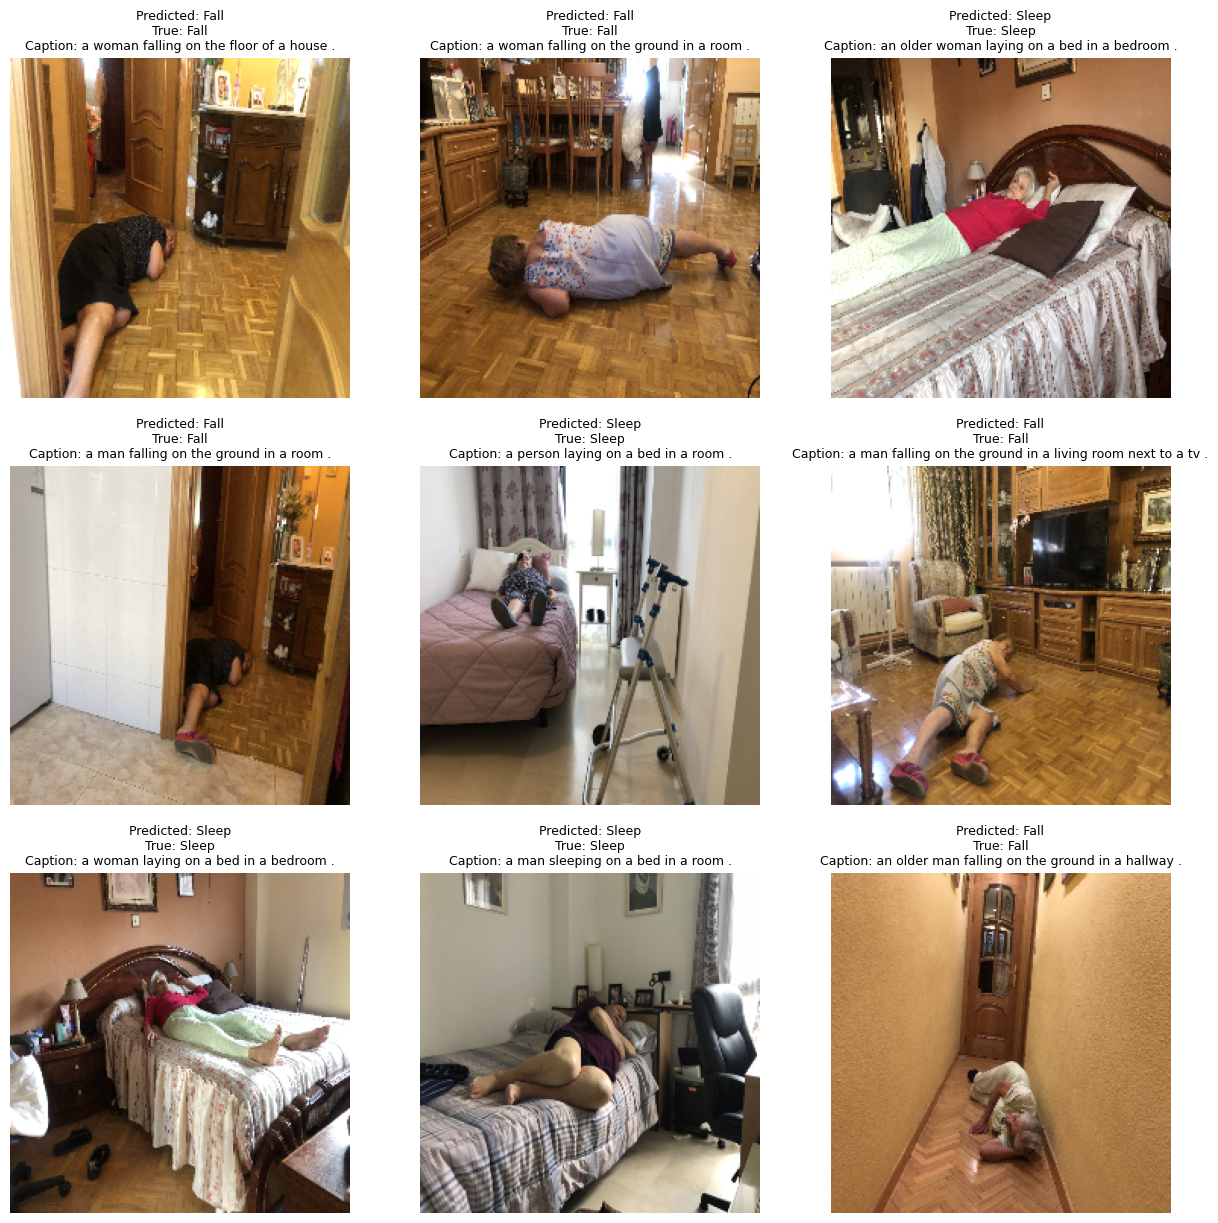

In [ ]:
# 클래스 이름 정의 (예시)
class_names = ['Fall', 'Sleep']

# 예측 및 시각화 실행
predict_and_visualize(fusion_model, test_dataset, class_names)